In [64]:
# ! pip install --upgrade tensorflow-hub

In [65]:
#! kaggle competitions download -c sliced-s01e05-WXx7h8

In [66]:
# Standard stack
import datetime
import pandas as pd
import numpy as np
import re

# Visualization
from pandas_profiling import ProfileReport
#import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import tensorflow_hub as hub
try:
    from wurlitzer import sys_pipes
except:
    from colabtools.googlelog import CaptureLog as sys_pipes

# Scikit-learn packages
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# display
from IPython.core.magic import register_line_magic
from IPython.display import Javascript

# Constants

In [67]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"
label = "price"

# Load Data

In [68]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
submission = pd.read_csv(TEST_PATH)

In [103]:
train.head(1)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,9901706,cute big one bedroom,1904415,Natalie,Manhattan,Upper West Side,40.77789,-73.97701,Entire home/apt,180,1,0,NaN,NaN,1,0


In [102]:
train['name'] = train['name'] .str.lower()

In [104]:
train.shape

(34226, 16)

In [105]:
all_ds = train[['id','name','availability_365','price']]
all_ds = all_ds.fillna('missing')

In [109]:
temp = all_ds.sample(20000)

In [110]:
train_ds, test_ds = train_test_split(temp,test_size=0.2, random_state=42)

In [111]:
train_ds = train_ds.to_dict('list')
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)
train_ds = train_ds.map(lambda x: {
    "idx": x["id"],
    "label": x["price"],
    "availability": x["availability_365"],
    "sentence": x["name"]
})



test_ds = test_ds.to_dict('list')
test_ds = tf.data.Dataset.from_tensor_slices(test_ds)
test_ds = test_ds.map(lambda x: {
    "idx": x["id"],
    "label": x["price"],
    "availability": x["availability_365"],
    "sentence": x["name"]
})

In [112]:
for example in train_ds.take(3):
    print({attr_name: attr_tensor.numpy() for attr_name, attr_tensor in example.items()})

{'idx': 33288485, 'label': 90, 'availability': 0, 'sentence': b'quiet oasis in brooklyn with garden patio'}
{'idx': 33964102, 'label': 130, 'availability': 17, 'sentence': b'cozy morningside park, next to columbia university'}
{'idx': 31806847, 'label': 90, 'availability': 0, 'sentence': b'lovely room in brooklyn'}


In [113]:
def prepare_dataset(example):
    return {"sentence" : tf.strings.split(example["sentence"]), "availability":example["availability"]}, example["label"]

train_ds = train_ds.batch(64).map(prepare_dataset)
test_ds = test_ds.batch(64).map(prepare_dataset)

In [114]:
train_ds

<MapDataset shapes: ({sentence: (None, None), availability: (None,)}, (None,)), types: ({sentence: tf.string, availability: tf.int32}, tf.int32)>

In [ ]:
# Specify the model.
model_1 = tfdf.keras.RandomForestModel(num_trees=30)

# Optionally, add evaluation metrics.
model_1.compile(metrics=["accuracy"])

# Train the model.
#with sys_pipes():
#    model_1.fit(x=train_ds)
model_1.fit(x=train_ds)

250/250 [==============================] - 0s 445us/step


In [ ]:
evaluation = model_1.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

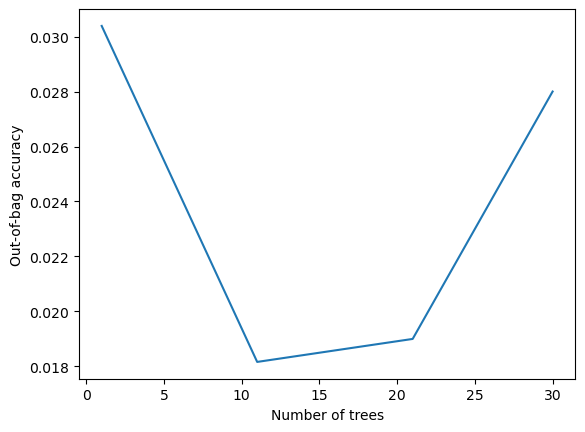

In [101]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag accuracy")
plt.show()

In [62]:
# Reinforcment Learning

In [63]:
# NNLM (https://tfhub.dev/google/nnlm-en-dim128/2) is also a good choice.
hub_url = "http://tfhub.dev/google/universal-sentence-encoder/4"
embedding = hub.KerasLayer(hub_url)

sentence = tf.keras.layers.Input(shape=(), name="sentence", dtype=tf.string)
embedded_sentence = embedding(sentence)

raw_inputs = {"sentence": sentence}
processed_inputs = {"embedded_sentence": embedded_sentence}
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

model_2 = tfdf.keras.RandomForestModel(
    preprocessing=preprocessor,
    num_trees=100)
model_2.compile(metrics=["accuracy"])

with sys_pipes():
  model_2.fit(x=train_ds)

KeyboardInterrupt: 

In [ ]:
1 + 1

# Preprocess

### Drop Columns

In [7]:
to_drop = ['id','host_id','host_name']

train = train.drop(to_drop,axis=1)
test = test.drop(to_drop,axis=1)

### Missing Values

In [8]:
def inpute_missing(dataset):
    """ 
    Edit this to fix nulls. Default version replaces all int/float with 0
    """
    for col in dataset.columns:
        if dataset[col].dtype not in [str, object]:
            dataset[col] = dataset[col].fillna(0)
        else:
            dataset[col] = dataset[col].fillna("UNKNOWN")
    return dataset

train = inpute_missing(train)
test = inpute_missing(test)

### NLP

In [9]:
def nlp_transforms(dataset):
    """ 
    NLP tranforms here. Default, None...
    """
    return dataset

train = nlp_transforms(train)
test = nlp_transforms(test)

### Computations

In [10]:
train.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Cute big one bedroom,Manhattan,Upper West Side,40.77789,-73.97701,Entire home/apt,180,1,0,UNKNOWN,0.00,1,0
1,Feel like you never leave your home,Brooklyn,East New York,40.66795,-73.89232,Entire home/apt,100,1,119,2019-06-30,1.39,2,289
2,Pristine Lower East Side Sanctuary,Manhattan,Lower East Side,40.72007,-73.98946,Entire home/apt,133,14,177,2019-05-03,2.82,2,221
3,"Luxe, Spacious 2BR 2BA Nr Trains",Brooklyn,Gowanus,40.66862,-73.99260,Entire home/apt,260,30,3,2014-08-04,0.03,1,316
4,1BD brownstone apt in Fort Greene!,Brooklyn,Fort Greene,40.68935,-73.96950,Entire home/apt,120,3,22,2015-10-28,0.27,1,189


In [11]:
input_1 = tf.keras.Input(shape=(1,), name="name", dtype="string")
input_2 = tf.keras.Input(shape=(1,), name="neighbourhood_group", dtype="string")
input_3 = tf.keras.Input(shape=(1,), name="neighbourhood", dtype="string")
input_4 = tf.keras.Input(shape=(1,), name="latitude", dtype="float")
input_5 = tf.keras.Input(shape=(1,), name="longitude", dtype="float")
input_6 = tf.keras.Input(shape=(1,), name="room_type", dtype="string")
input_7 = tf.keras.Input(shape=(1,), name="price", dtype="float")
input_8 = tf.keras.Input(shape=(1,), name="minimum_nights", dtype="float")
input_9 = tf.keras.Input(shape=(1,), name="number_of_reviews", dtype="float")
input_10 = tf.keras.Input(shape=(1,), name="last_review", dtype="string")
input_11 = tf.keras.Input(shape=(1,), name="reviews_per_month", dtype="float")
input_12 = tf.keras.Input(shape=(1,), name="calculated_host_listings_count", dtype="float")
input_13 = tf.keras.Input(shape=(1,), name="availability_365", dtype="float")


nn_raw_inputs = [input_1, input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11,input_12,input_13]

In [12]:
Normalization = tf.keras.layers.experimental.preprocessing.Normalization
CategoryEncoding = tf.keras.layers.experimental.preprocessing.CategoryEncoding
StringLookup = tf.keras.layers.experimental.preprocessing.StringLookup

# Numerical
values = train["latitude"].values
input_4_normalizer = Normalization()
input_4_normalizer.adapt(values)

values = train["longitude"].values
input_5_normalizer = Normalization()
input_5_normalizer.adapt(values)

values = train["price"].values
input_7_normalizer = Normalization()
input_7_normalizer.adapt(values)

values = train["minimum_nights"].values
input_8_normalizer = Normalization()
input_8_normalizer.adapt(values)

values = train["number_of_reviews"].values
input_9_normalizer = Normalization()
input_9_normalizer.adapt(values)

values = train["reviews_per_month"].values
input_11_normalizer = Normalization()
input_11_normalizer.adapt(values)

values = train["calculated_host_listings_count"].values
input_12_normalizer = Normalization()
input_12_normalizer.adapt(values)

values = train["availability_365"].values
input_13_normalizer = Normalization()
input_13_normalizer.adapt(values)

# String (https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/StringLookup)
values = train["name"].values
input_1_indexer = StringLookup()
input_1_indexer.adapt(values)
input_1_onehot = CategoryEncoding(output_mode="binary", max_tokens=4)

values = train["neighbourhood_group"].values
input_2_indexer = StringLookup()
input_2_indexer.adapt(values)
input_2_onehot = CategoryEncoding(output_mode="binary", max_tokens=4)

values = train["neighbourhood"].values
input_3_indexer = StringLookup()
input_3_indexer.adapt(values)
input_3_onehot = CategoryEncoding(output_mode="binary", max_tokens=4)

normalized_input_1 = input_1_onehot(input_1_indexer(input_1))
normalized_input_2 = input_2_onehot(input_2_indexer(input_2))
normalized_input_3 = input_3_onehot(input_3_indexer(input_3))
normalized_input_4 = input_4_normalizer(input_4)
normalized_input_5 = input_5_normalizer(input_5)

nn_processed_inputs = [normalized_input_1,normalized_input_2,normalized_input_3, normalized_input_4]

In [13]:
y = tf.keras.layers.Concatenate()(nn_processed_inputs)
y = tf.keras.layers.Dense(16, activation=tf.nn.relu6)(y)
last_layer = tf.keras.layers.Dense(8, activation=tf.nn.relu, name="last")(y)

# "3" for the three label classes. If it were a binary classification, the
# output dim would be 1.
classification_output = tf.keras.layers.Dense(2)(y)

nn_model = tf.keras.models.Model(nn_raw_inputs, classification_output)

# To reduce the risk of mistakes, group both the decision forest and the
# neural network in a single keras model.
nn_without_head = tf.keras.models.Model(inputs=nn_model.inputs, outputs=last_layer)
df_and_nn_model = tfdf.keras.RandomForestModel(preprocessing=nn_without_head,task=tfdf.keras.Task.REGRESSION)

In [22]:
nn_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"])

In [23]:
nn_model.fit(x=train_ds, validation_data=test_ds, epochs=10, verbose=False)
print("Evaluation:", nn_model.evaluate(test_ds))

NameError: name 'train_ds' is not defined

# Split & Train

In [232]:
#to_drop = ['name']

#train = train.drop(to_drop,axis=1)
#test = test.drop(to_drop,axis=1)

In [233]:
X_train, X_test = train_test_split(train,test_size=0.2, random_state=42)

train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label=label,task=tfdf.keras.Task.REGRESSION)
test_tf = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, label=label,task=tfdf.keras.Task.REGRESSION)
predictions = tfdf.keras.pd_dataframe_to_tf_dataset(test,task=tfdf.keras.Task.REGRESSION)

In [234]:
## Models

In [235]:
# A more complex, but possibly, more accurate model.
models = {
    'rf_baselines': tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION),
    'rf_tune1': tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task = tfdf.keras.Task.REGRESSION),
    'gbt_baselines': tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION),
    'gbt_tune1': tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1",task = tfdf.keras.Task.REGRESSION)
    }

evaluation = {}
for key in models:
    print(key)
    #Evaluate: metric logsloss: BinaryCrossentropy
    models[key].compile(metrics=["mean_squared_logarithmic_error"])
    
    #with sys_pipes():
    models[key].fit(x=train_tf)
    evaluation[key] = models[key].evaluate(test_tf, return_dict=True)

rf_baselines
107/107 [==============================] - 3s 27ms/step - loss: 0.0000e+00 - mean_squared_logarithmic_error: 0.2341
rf_tune1
107/107 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - mean_squared_logarithmic_error: 0.2382
gbt_baselines
107/107 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mean_squared_logarithmic_error: 0.2636
gbt_tune1
107/107 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mean_squared_logarithmic_error: 0.2545


In [236]:
evaluation

{'rf_baselines': {'loss': 0.0,
  'mean_squared_logarithmic_error': 0.23409005999565125},
 'rf_tune1': {'loss': 0.0,
  'mean_squared_logarithmic_error': 0.23822546005249023},
 'gbt_baselines': {'loss': 0.0,
  'mean_squared_logarithmic_error': 0.2635546624660492},
 'gbt_tune1': {'loss': 0.0,
  'mean_squared_logarithmic_error': 0.2544563412666321}}

In [237]:
evaluation

{'rf_baselines': {'loss': 0.0,
  'mean_squared_logarithmic_error': 0.23409005999565125},
 'rf_tune1': {'loss': 0.0,
  'mean_squared_logarithmic_error': 0.23822546005249023},
 'gbt_baselines': {'loss': 0.0,
  'mean_squared_logarithmic_error': 0.2635546624660492},
 'gbt_tune1': {'loss': 0.0,
  'mean_squared_logarithmic_error': 0.2544563412666321}}

In [91]:
# The hyper-parameter templates of the Gradient Boosted Tree model.
print(tfdf.keras.RandomForestModel.predefined_hyperparameters())

[HyperParameterTemplate(name='better_default', version=1, parameters={'winner_take_all': True}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


# Predictions

In [96]:
models

{'rf_baselines': <tensorflow_decision_forests.keras.RandomForestModel at 0x7fe843953fd0>,
 'rf_tune1': <tensorflow_decision_forests.keras.RandomForestModel at 0x7fe842f2e340>}

In [97]:
scores = models['rf_baselines'].predict(predictions)

In [98]:
scores

array([[350.86887],
       [139.08098],
       [ 68.81485],
       ...,
       [159.41724],
       [227.62271],
       [152.61357]], dtype=float32)

In [99]:
submission['price'] = scores

In [100]:
submission.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
0,10449807,Charming Lofty 1bd on Quiet Street,2981910,Daphne,Manhattan,Greenwich Village,40.73466,-73.99539,Entire home/apt,1,0,NaN,NaN,1,0,350.868866
1,1178389,"Beautiful, clean 1-bdrm private apt",6447462,Adam,Manhattan,Washington Heights,40.85060,-73.94023,Entire home/apt,6,19,2017-07-24,0.26,1,188,139.080978
2,23838063,Spacious getaway room in the heart of Bushwick,149073048,Kat,Brooklyn,Bushwick,40.69837,-73.93045,Private room,5,34,2019-06-30,2.31,1,102,68.814850
3,14415799,East Williamsburg Cozy Apartment with Rooftop!,48113730,Anastasia & Jeremy,Brooklyn,Williamsburg,40.70749,-73.93916,Entire home/apt,2,2,2016-10-16,0.06,1,0,142.880447
4,6555262,Comfortable and Spacious Bedroom,14098887,Fareed,Queens,Ridgewood,40.70503,-73.91433,Private room,2,0,NaN,NaN,1,0,61.425510


In [101]:
submit = submission[['id','price']]

In [102]:
submit.head()

,id,price
0,10449807,350.868866
1,1178389,139.080978
2,23838063,68.814850
3,14415799,142.880447
4,6555262,61.425510


In [107]:
submit.head()

,id,price
0,10449807,350.868866
1,1178389,139.080978
2,23838063,68.814850
3,14415799,142.880447
4,6555262,61.425510


In [108]:
submit.to_csv('submission.csv', index=False)

In [111]:
! kaggle competitions submit -c sliced-s01e05-WXx7h8 -f submission.csv -m "Message"

100%|█████████████████████████████████████████| 263k/263k [00:00<00:00, 279kB/s]
Successfully submitted to SLICED s01e05